# Themes in Nineteenth Century Song Sheets 

In [507]:
import requests
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import re
import time
import xml.etree.ElementTree as ET
import xmltodict
import pickle 
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import Tree
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geopandas
import geopy
from geopy.geocoders import Nominatim
import folium
from collections import Counter

# Introduction

I was inspired by a post about the Billboard Hot 100 songs from Professor Anderson's DIGHUM 100 class. In it, the poster didn't believe there would be common themes among the songs because artists create through inspiration, but are inspired by different things, so the songs would end up different. 

I though that couldn't be the case, so I decided to investigate myself - except I added a dimension of time because in addition to looking for themes, I also wanted to see if these themes from a different era would be recognizable and relatable to us today.

### What is a song sheet? 

According to the Library of Congress, these were lyric sheets the general populace could afford and hit peak popularity during the early 19th century.

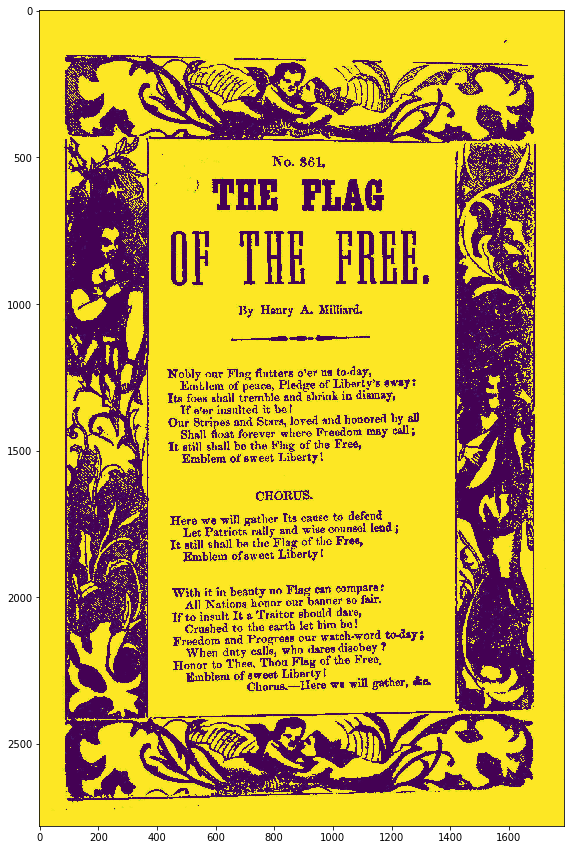

In [400]:
pic = mpimg.imread('1789.png')
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(pic, interpolation='nearest');

# Research Questions

1. Do themes exist?  
2. What are these themes? 

Hypothesis: I think there definetly will be common themes. As for themes, I can only guess those which are universal to the human experience: happiness & love, sadness, government propaganda, and alcohol. 

# Materials and Methods

### Getting the URL codes for each of the song sheets 

The overwhelming majority of the song sheets from the Library of Congress's Nineteenth Century Song Sheet Collection are available in xml format at its given url. So I created a function to extract text from the xml urls

In [401]:
def extract_text(xml_url):
    t = []
    d = xmltodict.parse(requests.get(xml_url).text)
    #this gets to text in ordereded dictionary format
    od = d['TEI']['text']['body']['div']
    #sometimes the documents aren't actually ocr'd and the xml file is blank
    #the "if" statement is to avoid those and just return an empty list instead
    try: 
        if 'lg' in od.keys():
            text = od['lg']
            #now we are just looking for the text
            for i in text:
                    if type(i['l']) == list:
                        t.extend(i['l'])
    except TypeError:
        t.append('Type error occured. Probably because xml file is actually empty')
    return t 

Would occasionally get errors due to empty xmls, example below. So added a 'try and except' to make the function more flexible. 

In [291]:
extract_text('http://lcweb2.loc.gov/natlib/ihas/warehouse/amss/as106510/as106510.xml')

['Type error occured. Probably because xml file is actually empty']

This code below goes through all the pages on the song sheet collection website and saves the xml_urls and the full extracted texts into a list. Since running this codes takes a long time, I actually ran the code in Google Colab Notebook and then saved the results into a txt file which I then used the pickle module to import the results back into this Notebook

In [201]:
start = time.time()
num = 1 #the page number the code is current scrapping
ware = re.compile('warehouse') #the xml files have a unique identifier word, 'warehouse', this regex searches for it in the xml urls
xml_urls = [] 
full_texts = []
titles = []
page = requests.get('https://www.loc.gov/collections/nineteenth-century-song-sheets/?fo=json').json()
num = 0 
#iterating through all the subsequent pages 
while True:  
    results = page['results']
    for i in range(len(results)):
        titles.append(results[i]['title'])
        #below three lines look for xml url
        song_sheet = requests.get(results[i]['url'])
        soup = BeautifulSoup(song_sheet.content, 'html.parser')
        s = soup.find_all('a', {'target':'_blank'}, href=True)  #looking for the xml urls 
        for i in s:
            if ware.search(i['href']):
                xml_urls.append(i['href'])
                full_texts.append(extract_text(i['href']))
    #getting the next page, code from the Library of Congress tutorial: link: https://github.com/LibraryOfCongress/data-exploration/blob/master/LOC.gov%20JSON%20API.ipynb
    next_page = page["pagination"]["next"] #get the next page url
    if next_page is not None: #make sure we haven't hit the end of the pages
        page = requests.get(next_page).json()
    else:
        break #we are done and can stop looping

end = time.time()
print("it took ", end - start, 'seconds to run')

it took  56.50306415557861 seconds to run


The extract_text function ran into some error on the 1835th item, as that xml file was actually empty so I saved the texts scraped before then, fixed the extract_text function and picked it up from there. Below code loads previous round of scraping in. 

In [293]:
with open('full_texts.txt', 'rb') as file:
    full_texts = pickle.load(file)

In [294]:
with open('titles.txt', 'rb') as file:
    titles = pickle.load(file)

#### Continuing collecting texts

It stopped on the 74th page, so we pick up there again (I will remove the 10 or so duplicates later) 

In [302]:
start = time.time()
num = 1 #the page number the code is current scrapping
ware = re.compile('warehouse') #the xml files have a unique identifier word, 'warehouse', this regex searches for it in the xml urls
xml_urls2 = [] 
full_texts2 = []
titles2 = []
page = requests.get('https://www.loc.gov/collections/nineteenth-century-song-sheets/?fo=json&sp=74').json()
pagescraped = 0
#iterating through all the subsequent pages 
while True:  
    print("Pages scraped counter: ", 74 + pagescraped)
    results = page['results']
    for i in range(len(results)):
        titles2.append(results[i]['title'])
        #below three lines look for xml url
        song_sheet = requests.get(results[i]['url'])
        soup = BeautifulSoup(song_sheet.content, 'html.parser')
        s = soup.find_all('a', {'target':'_blank'}, href=True)  #looking for the xml urls 
        for i in s:
            if ware.search(i['href']):
                xml_urls2.append(i['href'])
                full_texts2.append(extract_text(i['href']))
    #getting the next page, code from the Library of Congress tutorial: link: https://github.com/LibraryOfCongress/data-exploration/blob/master/LOC.gov%20JSON%20API.ipynb
    next_page = page["pagination"]["next"] #get the next page url
    if next_page is not None: #make sure we haven't hit the end of the pages
        page = requests.get(next_page).json()
        pagescraped += 1
    else:
        break #we are done and can stop looping

end = time.time()
print("it took ", end - start, 'seconds to run')

Pages scraped counter:  74
Pages scraped counter:  75
Pages scraped counter:  76
Pages scraped counter:  77
Pages scraped counter:  78
Pages scraped counter:  79
Pages scraped counter:  80
Pages scraped counter:  81
Pages scraped counter:  82
Pages scraped counter:  83
Pages scraped counter:  84
Pages scraped counter:  85
Pages scraped counter:  86
Pages scraped counter:  87
Pages scraped counter:  88
Pages scraped counter:  89
Pages scraped counter:  90
Pages scraped counter:  91
Pages scraped counter:  92
Pages scraped counter:  93
Pages scraped counter:  94
Pages scraped counter:  95
Pages scraped counter:  96
Pages scraped counter:  97
Pages scraped counter:  98
Pages scraped counter:  99
Pages scraped counter:  100
Pages scraped counter:  101
Pages scraped counter:  102
Pages scraped counter:  103
Pages scraped counter:  104
Pages scraped counter:  105
Pages scraped counter:  106
Pages scraped counter:  107
Pages scraped counter:  108
Pages scraped counter:  109
Pages scraped coun

In [304]:
with open('full_texts2.txt', 'wb') as f:
    pickle.dump(full_texts2, f)
    
with open('xml_urls2.txt', 'wb') as f:
    pickle.dump(xml_urls2, f)

with open('titles2.txt', 'wb') as f:
    pickle.dump(titles2, f)

In [321]:
no_duplicates = full_texts2[11:] #some texts got scraped twice because of the error happening in the middle, this removes duplicates 
everything =  full_texts + no_duplicates

### Done scraping text!

In [336]:
text = pd.DataFrame({'Full Text': everything})
text.head()

,Full Text
0,"[Nobly our Flag flutters o'er us to-day,, Embl..."
1,[Long wave our proud Stars and Stripes of libe...
2,"[""A song for our banner"" the watchword recall,..."
3,"[RESPECTFULLY INSCRIBED TO, General Sam. Houst..."
4,"[On Freedom's altar glows a fire;, Hurrah, hur..."


In [337]:
titles = pd.DataFrame({'Titles':titles + titles2})
titles.head()

,Titles
0,The flag of the free. By Henry A. Milliard
1,The flag of the republic. Air: I'm Afloat - By...
2,"The flag of our Union! Thos G. Doyle, Booksell..."
3,For the Union we'll die. By Dr. W. S. Hurlocke...
4,"Freedom's altar. A.W. Auner, Song Publisher, 1..."


# Latent Dirichlet Allocation 

In order to examine the themes among these song sheets, I chose to use LDA topic modeling, and applied it like how it was taught in DIGHUM101 Week 5 Topic Modeling notebook

Step 1: Cleaning the Data

In [367]:
#makes list of list of strings into list of strings
flatten = list(itertools.chain(*everything))
#removes the None values
flatten = [x for x in flatten if x is not None]
#concatenates everything into a single string
flatten  = ' '.join(flatten)
#removes unicode character 
flatten.replace('â\x80\x94', '')
#splits it into tokens and makes it all lowercase
flatten  = flatten.lower().split()
#remove anythin that is not a letter
flatten = [word for word in flatten if word.isalpha()]

Step 2: Making the Tfidf Vectorizer

In [371]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, max_features = 5000, stop_words = "english")
tfidf = tfidf_vectorizer.fit_transform(flatten)

Step 3: Fitting the LDA Model

In [372]:
lda = LatentDirichletAllocation(n_components = 7, max_iter = 20, random_state = 3)
lda = lda.fit(tfidf)

Step 4: Borrowing Professor Muzzall's most common topic words function

In [373]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
print()

In [374]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
thy flag away life sing took god hearts world father days way free wish quite big head morning dealer bless

Topic #1:
like heart long land day says thou fight battle friends oh noble glory unto lay banner heaven set mighty comes

Topic #2:
old shall love little got brave went look gallant dey stars gone gave eyes yankee dat sad ob freedom sons

Topic #3:
man home poor thee true thought ye hear far night loved war death light rebels people save red half earth

Topic #4:
let come dear make tell chatham time union think left happy bright new mother heard hope country live southern cause

Topic #5:
did sweet know great came meet boys fair say leave song saw toy sure met going voice john dark run

Topic #6:
young good soon till just said men round white right wid hard years stand better hand glorious pretty marching bold


Step 5: Visualization  (also from Prof. Muzzall's 5-1 topic modelling notebook) 

In [375]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
pyLDAvis.display(panel)

C:\Users\Sarah\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Geotagging

In [442]:
#code source: https://stackoverflow.com/questions/48660547/how-can-i-extract-gpelocation-using-nltk-ne-chunk, answered by alvas and edited by Captain._Nemo
def get_continuous_chunks(text, label):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == label:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

Some of these locations seemed very dubious (for example 'No No No No' and its variations)  so I downloaded the Census's table of population estimates, which has a list of all the incorporated places, and checked the locations against that list as a form of validation

In [ ]:
locations = get_continuous_chunks(t, 'GPE')

In [521]:
census = pd.read_csv('sub-est2019_all.csv', encoding = "ISO-8859-1")
names = census['NAME'].tolist() + census['STNAME'].tolist()
names = " ".join(names)

Originally there were over 1 thousand "locations" that were picked up, so this process really cut down a lot.

In [524]:
refined = [l for l in locations if 'No' not in l]
refined = [l for l in refined if l in names]
print(len(refined))

150


The following geotagging portion was greatly guided by a very useful tutorial called, 'Geocode with Python' by Abdishakur, URL: https://towardsdatascience.com/geocode-with-python-161ec1e62b89

In [525]:
locator = Nominatim(user_agent='myGeocoder')
coordinates = []
for loc in refined:
    coordinates.append(locator.geocode(loc + ", United States")) #restrict to United States because these are American song sheets
    
valid_locations = [refined[i] for i in range(len(coordinates)) if coordinates[i] is not None]
valid_coord = [c for c in coordinates if c is not None]

latitudes = [c.latitude for c in valid_coord]
longitudes = [c.longitude for c in valid_coord]

geo = pd.DataFrame({"Location": valid_locations, "Latitudes":latitudes, "Longitudes": longitudes})
geo

,Location,Latitudes,Longitudes
0,Balt,37.516302,-121.977244
1,Baltimore,39.290882,-76.610759
2,Portland,45.520247,-122.674195
3,New York,40.712728,-74.006015
4,Virginia,37.123224,-78.492772
...,...,...,...
143,Katy,29.785785,-95.824396
144,Kentuck,36.659860,-79.298354
145,Wales,48.895837,-98.602621
146,Scotch,37.275293,-116.370632


In [589]:
# code based off of 'Geocode with Python' by Abdishakur URL:  https://towardsdatascience.com/geocode-with-python-161ec1e62b89
map1 = folium.Map(
    location=[29.917204,-95.087391],
    tiles='cartodbpositron',
    zoom_start=12,
)

geo.apply(lambda row:folium.Marker(location=[row["Latitudes"], row["Longitudes"]], popup = row['Location']).add_to(map1), axis=1)
map1

# Where's all the songs about alcohol? 

It was at this point I realized I hadn't really seen any indication of songs dedicated to alcohol. Could it really be that small? This section investigates it further. 

In [555]:
#unesting the original text dataframe 
t = text['Full Text'].tolist() 
os = []
for i in t:
    f = filter(None, i)
    os.append(" ".join(f))
text = pd.DataFrame({'Full Text':os})
text.head()

,Full Text
0,"Nobly our Flag flutters o'er us to-day, Emblem..."
1,Long wave our proud Stars and Stripes of liber...
2,"""A song for our banner"" the watchword recall, ..."
3,RESPECTFULLY INSCRIBED TO General Sam. Houston...
4,"On Freedom's altar glows a fire; Hurrah, hurra..."


Joe Satran of the HuffPost found an old newspaper clipping from Chronicling America (a database with digitized old newspapers of America hosted by the Library of Congress) published in 1901 with a list of popular words regarding alcohol. I've compiled some into a list below in hopes of getting more period correct terminology. URL: https://www.huffpost.com/entry/vintage-slang-terms-drunk_n_4268480

In [585]:
huff = ["John Barleycorn", "Sr. John", "champagne", 'drunk', 'fish bait', 'Tanks', 'Shagrun', 
        'thimble', 'hill of beans', 'hot as winks', 'pig iron', 'caraway seed', 'crapulent',
       'soshed', 'nulled', 'gravel rash', 'indentures with his legs', 'one and thirty', "dagg'd", 'swiped', 'obfuscate', 'podgy', 'black bottle',
       'bowned', 'beargeared', 'bemused', 'stewed', 'up in the air', 'tacking', 'tack', 'put under the table',
       'fixed all right', 'fighting the booms', 'tanked up', 'tamarack', 'all to the bad', 'licking up', 'water wart', 'sosh',
       'still on', 'sapping up', "David's sow", 'boiled owl', 'week on his pins', 'mops and brooms', 'cast up', 'john']

In [586]:
# some synonyms for alcohol
alcohol = ["""aqua vitae, ardent spirits, booze, bottle, drink, firewater, grog, hooch,
           inebriant, intoxicant, John Barleycorn, juice, liquor, lush, moonshine, potable, rum, sauce, spirits, stimulant, strong drink, tipple, alcohol,
          whiskey, aperitif, bracer, chaser, digestif, nightcap,
            belt, load, nip, peg, pop, shooter, shot, slug, snifter, snort, tot, whet,
            cocktail, mixed drink
            ale, beer, brew, brewage, brewski, home brew, malt liquor, microbrew, mum, nappy,
            mead, sake, wine
            barley-bree, barley-broo, brandy, gin, liqueur, mao-tai, mescal, schnapps, tequila, vodka, whiskey, whisky,
            Dutch courage, licur, bouse, boozer, dip, dipso, swiper, swizzler, blootered, buffy, dead-oh, half-shot, lushy, 
            scammered, shicker, sozzled, squiffed, squiffy, squizzed, tanked,shickery"""]
alcohol = [a.split() for a in alcohol][0] + huff
def contains_alc(text):
    if text is None or len(text) ==0:
        return False
    for i in alcohol:
        if i in text:
            return True
        return False

text['Contains Alcohol Reference?'] = text['Full Text'].map(lambda x:contains_alc(x))

Even with all these words for alcohol, there were only 5 song sheets that had a match, which is much lower than I expected.

In [587]:
text.groupby('Contains Alcohol Reference?').count()

,Full Text
Contains Alcohol Reference?,
False,4285
True,5


# Results 

In [528]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
thy flag away life sing took god hearts world father days way free wish quite big head morning dealer bless

Topic #1:
like heart long land day says thou fight battle friends oh noble glory unto lay banner heaven set mighty comes

Topic #2:
old shall love little got brave went look gallant dey stars gone gave eyes yankee dat sad ob freedom sons

Topic #3:
man home poor thee true thought ye hear far night loved war death light rebels people save red half earth

Topic #4:
let come dear make tell chatham time union think left happy bright new mother heard hope country live southern cause

Topic #5:
did sweet know great came meet boys fair say leave song saw toy sure met going voice john dark run

Topic #6:
young good soon till just said men round white right wid hard years stand better hand glorious pretty marching bold


# Discussion

#### Q: Are there themes? 

Given the topics returned, I think there definetly is a case for the presence of themes. 


#### Q: What are these themes? 

A significant portion of these topics have patriotic/war related terms (more than I expected) which in a sense fall under government propaganda, so this theme can be considered as having considerable evidence. Topic #1 is a good example, with words like fight, battle, glory, banner, mighty. Thinking about it more closely though, this is not extremely suprising as the nineteenth century had its fair share of wars, like the War of 1812 and the Civil War. 

Interestingly, words related to happiness and sadness can be found in  every topic, perhaps suggesting these are universal themes that to some degree are present in nearly every song. This supports the theory humans experience similar emotions regardless of time, as these songs are from the 19th century. 

Lastly, one particular outlier: the word 'john' in topic #5. John could possibly be referencing alcohol as the HuffPost article mentions the term John Barleycorn as related to alcohol. However, further analysis would be needed to ensure whether or not john is being used here as a metaphor or a proper noun.  

#### Geotagging: 
I tried my best to remove fake location matches, but I'm sure a couple slipped through. However, the resulting map with the locations tagged is actually not too suprising as it roughly mirrors what one would expect a population density map to look like (with the East Coast being more populous as it was settled first). This supports the notion that these song sheets basically went where the people went. 

#### Future research: 
Many of the titles actually had street addresses listed in them, but because extracting them is rather difficult due to their unstandardized format, I was unable to do it for this project. Thus it would be interesting if I had more time to more acurrately geotag these locations. These locations could then be used as a proxy to guess where the epicenters of the 19th century song sheet craze could be. 

### Limitations

#### Sampling bias
The curators of this collection likely had a mindset of collecting whatever they could find, rather than randomly selecting the song sheets they came accross. Furthermore, it is likely song sheet preservation was uneven, perhaps with governments taking care of patriotic song sheets more, and the regular citizen discarding their song sheets after becoming uneeded. Thus there is high probability the corpus I collected has somewhat of a sampling bias. 

#### Computational techniques
The aforementioned issues with Geotagging inaccurately tagging locations. 

## Conclusion

Given the results of the topic modeling, there were definetly a significant proportion of songs with emotions we can relate to today, 
suggesting it may not be too far fetched to believe that although experiences may vary, emotions can be similar, regardless of time (though this research only limited to 19th century America).

# Works Cited

Abdishakur. “Geocode with Python.” *Towards Data Science,* Medium, 18 Sept. 2019, towardsdatascience.com/geocode-with-python-161ec1e62b89.

@alvas. “How Can I Extract GPE(Location) Using NLTK ne_chunk?” Edited by @Captain.\_Nemo, *Stack Overflow,*  Stack Exchange, 8 Sept. 2018, stackoverflow.com/questions/48660547/how-can-i-extract-gpelocation-using-nltk-ne-chunk.

Muzzall, Evan. '5-1_topic-modeling.' *GitHub*, 21 Jun. 2020 https://github.com/dlab-berkeley/DIGHUM101-2020/blob/master/Notebooks/Week5/5-1_topic-modeling.ipynb